In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append("../BBTRE_physics_analysis/") 

In [3]:
import numpy as np
from xmitgcm import open_mdsdataset 
from xhistogram.xarray import histogram

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [4]:
def checklist():
    return f"""Checklist for running variable resolution experiments:

Directory structure:
  [x] Copy input and code files from reference simulation
  [x] Run Jupyter notebook to create input files

/input files:
  data
    [ ] Change iter0 to 0
  data.diagnostics
    [ ] Turn off other Ptracers

[ ] Submit execution batch script
[ ] Check that the job runs succesfully!
"""

In [5]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 15.

In [28]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["budgetDiag"], delta_t=delta_t)
ds = ds.isel(time=0)
ds, grid = add_rotated_coords(ds, θ)

geo = xr.open_dataset(data_dir+"geocoords.nc")
ds['Depth_actual'] = xr.zeros_like(ds['Depth']) - geo['z_actual'].values

dx = 600.; dy = 600.;
Ly = ds.YC.size*dy
Lx = ds.XC.size*dx

ds.attrs["dx"] = dx;
ds.attrs["dy"] = dy;
ds.attrs["Lx"] = Lx;
ds.attrs["Ly"] = Ly;

### Initialize tracers

In [29]:
δz = 40.
δx = 0.5e4
δy = 0.5e4
lon = -18.3;
lat = -21.7;

xy_inj = np.sqrt((geo['lon'] - lon)**2 + (geo['lat'] - lat)**2).argmin()
ij = xy_inj.values
i = ij//geo["z"].shape[1]
j = (ij-i*geo["z"].shape[1])%geo["z"].shape[0]

x = ds['XC'].isel(XC = i).values;
y = ds['YC'].isel(YC = j).values;
z1 = (ds.H - ds["Depth"].isel(XC = i, YC = j) + 1050.).values

C1 = np.exp(- ((ds["XC"] - x)/δx)**2)
C1, _ = xr.broadcast(C1, ds["hFacC"])
C1 = C1.where(ds["Z"] < z1, 0.)
C1 = C1.assign_coords({"Xr": ds["Xr"], "Zr": ds["Zr"]})

z2 = (ds.H - ds["Depth"].isel(XC = i, YC = j) + 150.).values
C2 = np.exp(- ((ds["Zr"] - z2)/δz)**2)
C2, _ = xr.broadcast(C2, ds["hFacC"])
C2 = C2.where(ds["XC"] > x, 0.)
C2 = C2.assign_coords({"Xr": ds["Xr"], "Zr": ds["Zr"]})

(50.0, 2000.0)

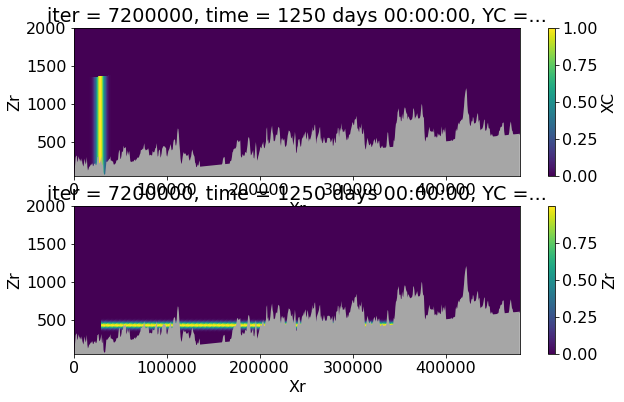

In [30]:
plt.subplot(2,1,1)
C1.isel(YC=j).plot(x="Xr", y="Zr")
thalweg = (ds.H - ds['Depthr']).min("YC")
plt.fill_between(thalweg.XC, 0.*thalweg, thalweg, facecolor=nancol)
plt.ylim(50, 2000)

plt.subplot(2,1,2)
C2.isel(YC=j).plot(x="Xr", y="Zr")
plt.fill_between(thalweg.XC, 0.*thalweg, thalweg, facecolor=nancol)
plt.ylim(50, 2000)

In [31]:
Clabels = ['TRAC01', 'TRAC02']
for Clabel, C in zip(Clabels, [C1, C2]):
    ds[Clabel] = C.transpose("Z", "YC", "XC")

### Create input files from last snapshot of model output

In [32]:
input_vars = {
    "UVEL": "U",
    "VVEL": "V",
    "THETA": "T",
    "KVDIFF": "kappa",
    "Depth": "topog",
    "drF": "delZ",
    "TRAC01": "Ch",
    "TRAC02": "Cv"
}

input_path = f"../../MITgcm/experiments/rotated_BBTRE_canyon-tracer-extremes/input/"
print(f"\n{input_path}")
new_ds = ds.copy()
new_ds["Depth"] = -new_ds["Depth"]

for (k, v) in input_vars.items():
    # save input data as binary files
    newFile = open(f"{input_path}{v}.init", "wb")
    newFile.write(bytes(new_ds[k].values.astype('>f8')))
    newFile.close()

checklist_name = f"{input_path}checklist.txt"
if not(os.path.exists(checklist_name)):
    f = open(checklist_name, "w")
    f.write(checklist())
    f.close()
else:
    print(" (Checklist file already exists!)")

os.system(f"cp ./restart_with_vertical_and_horizontal_tracers.ipynb {input_path}");


../../MITgcm/experiments/rotated_BBTRE_canyon-tracer-extremes/input/
 (Checklist file already exists!)
